In [ ]:
import numpy as np
import cv2
from skimage import metrics
from sklearn.feature_extraction import image
import matplotlib.pyplot as plt

upload data

In [ ]:
# Étape 1 : Installer PyDrive pour interagir avec Google Drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import os

# Étape 2 : Authentification
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Étape 3 : Télécharger le contenu du dossier
def download_folder(drive, folder_id, dest_path):
    """Télécharge tous les fichiers dans un dossier Google Drive public."""
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    for file in file_list:
        file_name = os.path.join(dest_path, file['title'])
        if file['mimeType'] == 'application/vnd.google-apps.folder':
            download_folder(drive, file['id'], file_name)  # Récursion pour sous-dossiers
        else:
            print(f"Téléchargement du fichier : {file['title']}")
            file.GetContentFile(file_name)

# Remplacer par l'ID du dossier partagé
folder_id = "1AN64B9rsSFGL1u8bUJzB9By_Np3fLZ1u"
dest_path = "./dataset"

download_folder(drive, folder_id, dest_path)

# Étape 4 : Vérifier les fichiers téléchargés
for root, dirs, files in os.walk(dest_path):
    for file in files:
        print(os.path.join(root, file))


Téléchargement du fichier : 06901.png
Téléchargement du fichier : 07102.png
Téléchargement du fichier : 06801.png
Téléchargement du fichier : 07201.png
Téléchargement du fichier : 07002.png
Téléchargement du fichier : 07101.png
Téléchargement du fichier : 07001.png
Téléchargement du fichier : 03602.png
Téléchargement du fichier : 04501.png
Téléchargement du fichier : 03503.png
Téléchargement du fichier : 04101.png
Téléchargement du fichier : 03802.png
Téléchargement du fichier : 06402.png
Téléchargement du fichier : 03902.png
Téléchargement du fichier : 04201.png
Téléchargement du fichier : 04002.png
Téléchargement du fichier : 04401.png
Téléchargement du fichier : 03901.png
Téléchargement du fichier : 04102.png
Téléchargement du fichier : 04001.png
Téléchargement du fichier : 03702.png
Téléchargement du fichier : 04202.png
Téléchargement du fichier : 03502.png
Téléchargement du fichier : 03601.png
Téléchargement du fichier : 03904.png
Téléchargement du fichier : 03903.png
Téléchargeme

---
Data Preparation

{'noise_level': 1264.783793296665, 'entropy': 7.064671721806573}


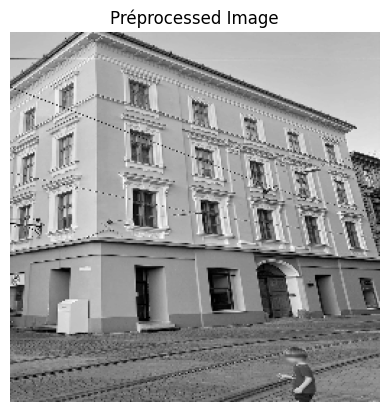

In [ ]:
from skimage.measure import shannon_entropy  # Correction de l'import

class DataPreparation:
    @staticmethod
    def preprocess_image(image_path):
        """Standardize the input image."""
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        return img

    @staticmethod
    def extract_features(img):
        """Extract features like noise level and entropy."""
        noise_level = np.var(img)  # Variance as a proxy for noise
        entropy = shannon_entropy(img)
        return {
            "noise_level": noise_level,
            "entropy": entropy
        }


# Préparer les données
prepared_data = DataPreparation.preprocess_image("./dataset/images_inter/04501.png")
feature = DataPreparation.extract_features(prepared_data)
print(feature)
# Afficher l'image avec Matplotlib
plt.imshow(prepared_data, cmap="gray")  # Assurez-vous que l'image est en niveaux de gris
plt.title("Préprocessed Image")
plt.axis("off")
plt.show()



---
Filtrage, contrast, threashold

In [91]:
class Filtrage:
    #filtrage--------------------------------------
    def apply_Gaussian_filter(img, kernel_size,sigmaX):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigmaX)

    def apply_median_filter(img, kernel_size):
        return cv2.medianBlur(img, kernel_size)

    def apply_mean_filter(img, kernel_size):
        return cv2.blur(img, (kernel_size, kernel_size))

class contrast:
    #contrast-------------------------------------
    def adjust_contrast_equalization(img):
      return cv2.equalizeHist(img)

    def adjust_contrast_clahe(img, clip_limit, tile_grid_size=(8, 8)):
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size, tile_grid_size))
        return clahe.apply(img)

class threshold:
    #threshold-----------------------------------
    def threshold_global(img, threshold):
      _, binary_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
      return binary_img

    def threshold_local(img, block_size, C):
      binary_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
      return binary_img


Segmentation

In [92]:
import cv2
import numpy as np

class Segmentation:
    @staticmethod
    def sobel(img, ksize, scale, delta, border_type=cv2.BORDER_DEFAULT):
        """
        Apply Sobel edge detection to the image.

        Parameters:
        - img: The input image
        - ksize: Kernel size
        - scale: Scale factor for the derivative
        - delta: Delta value added to the result
        - border_type: Border handling type (default is cv2.BORDER_DEFAULT)

        Returns:
        - Sobel magnitude (edges)
        """
        grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize, scale=scale, delta=delta, borderType=border_type)
        grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize, scale=scale, delta=delta, borderType=border_type)
        return cv2.magnitude(grad_x, grad_y)

    @staticmethod
    def canny(img, threshold1, threshold2, aperture_size, L2gradient=False):
        """
        Apply Canny edge detection to the image.

        Parameters:
        - img: The input image
        - threshold1: The first threshold for the hysteresis procedure
        - threshold2: The second threshold for the hysteresis procedure
        - aperture_size: Aperture size for the Sobel operator
        - L2gradient: Boolean to indicate whether to use the more accurate L2 gradient (default is False)

        Returns:
        - Binary image with edges detected
        """
        return cv2.Canny(img, threshold1, threshold2, apertureSize=aperture_size, L2gradient=L2gradient)


Parameters

In [ ]:
# this is an example of an action
action = [
    {"type": "filter", "method": "gaussian", "kernel_size": 3, "sigmaX": 0.1},
    {"type": "contrast", "method": "clahe", "clip_limit": 2.0, "tile_grid_size":(8, 8)},
    {"type": "threshold", "method": "global", "threshold": 127},
    {"type": "segmentation", "method": "sobel", "ksize": 3, "scale": 1, "delta": 0},
]

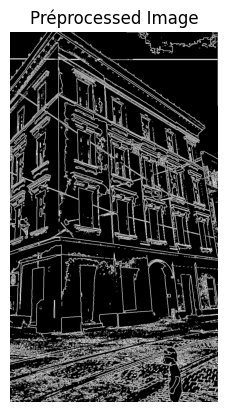

In [ ]:
# lets try to apply that action
img = cv2.imread("./dataset/images_inter/04501.png", cv2.IMREAD_GRAYSCALE)

for step in action:
    if step["type"] == "filter":
        if step["method"] == "gaussian":
            img = Filtrage.apply_Gaussian_filter(img, step["kernel_size"], step["sigmaX"])

        elif step["method"] == "median":
            img = Filtrage.apply_median_filter(img, step["kernel_size"])

        elif step["method"] == "mean":
            img = Filtrage.apply_mean_filter(img, step["kernel_size"])

    elif step["type"] == "contrast":
        if step["method"] == "equalization":
            img = contrast.adjust_contrast_equalization(img)

        elif step["method"] == "clahe":
            img = contrast.adjust_contrast_clahe(img, step["clip_limit"], step["tile_grid_size"])

    elif step["type"] == "threshold":
        if step["method"] == "global":
            img = threshold.threshold_global(img, step["threshold"])

        elif step["method"] == "local":
            img = threshold.threshold_local(img, step["block_size"], step["C"])

    elif step["type"] == "segmentation":
        if step["method"] == "sobel":
            img = Segmentation.sobel(img, step["ksize"], step["scale"], step["delta"])

        elif step["method"] == "canny":
            img = Segmentation.canny(img, step["threshold1"], step["threshold2"], step["aperture_size"])

# now lets see the image after the action
plt.imshow(img, cmap="gray")  # Assurez-vous que l'image est en niveaux de gris
plt.title("Préprocessed Image")
plt.axis("off")
plt.show()

In [58]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim

class QLearning:
    def __init__(self, actions, parameters, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.Q_table = {}
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.parameters = parameters

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action = []
            for step_type in self.actions:
                method = np.random.choice(self.actions[step_type])
                params = {}
                for param_name in self.parameters[step_type][method]:
                    # Ensure the parameter is one-dimensional
                    param_values = self.parameters[step_type][method][param_name]
                    if isinstance(param_values[0], (list, tuple)):  # Handle multi-dimensional parameters
                        # param_values = [tuple(p) for p in param_values]  # Flatten to tuples
                        param_values = [item for sublist in param_values for item in (sublist if isinstance(sublist, (list, tuple)) else [sublist])]
                    params[param_name] = np.random.choice(param_values)
                # Convert step to a tuple
                step = (step_type, method)
                for param_name in params:
                    step += (param_name, params[param_name])
                action.append(step)
            return tuple(action)
        else:
            # Exploitation: Choose the best action from the Q-table
            if state in self.Q_table:
                best_action = max(self.Q_table[state], key=lambda k: self.Q_table[state][k])
                return best_action
            else:
                # If state not in Q-table, choose a random action
                return self.choose_action(state)

    def update_Q(self, state, action, reward, next_state):
        best_next_q = max(self.Q_table.get(next_state, {}).values(), default=0.0)
        current_q = self.Q_table.get(state, {}).get(action, 0.0)
        self.Q_table.setdefault(state, {})[action] = current_q + self.alpha * (reward + self.gamma * best_next_q - current_q)

    def apply_actions(self, img, action):
        for step in action:
            step_type = step[0]
            method = step[1]
            params = {}
            i = 2
            while i < len(step):
                param_name = step[i]
                param_value = step[i+1]
                params[param_name] = param_value
                i += 2
            if step_type == "filter":
                if method == "gaussian":
                    img = Filtrage.apply_Gaussian_filter(img, params["kernel_size"], params["sigmaX"])
                elif method == "median":
                    img = Filtrage.apply_median_filter(img, params["kernel_size"])
                elif method == "mean":
                    img = Filtrage.apply_mean_filter(img, params["kernel_size"])
            elif step_type == "contrast":
                if method == "equalization":
                    img = contrast.adjust_contrast_equalization(img)
                elif method == "clahe":
                # Ensure tile_grid_size is passed as a tuple of two integers (int, int)
                    if isinstance(params["tile_grid_size"], list) and len(params["tile_grid_size"]) == 2:
                        tile_grid_size = tuple(params["tile_grid_size"])
                    else:
                    # If it's not a list with two integers, use a default (8, 8)
                        tile_grid_size = (8, 8)
                    img = contrast.adjust_contrast_clahe(img, params["clip_limit"], tile_grid_size)
            elif step_type == "threshold":
                if method == "global":
                    img = threshold.threshold_global(img, params["threshold"])
                elif method == "local":
                    img = threshold.threshold_local(img, params["block_size"], params["C"])
            elif step_type == "segmentation":
                if method == "sobel":
                    img = Segmentation.sobel(img, params["ksize"], params["scale"], params["delta"])
                elif method == "canny":
                    img = Segmentation.canny(img, params["threshold1"], params["threshold2"], params["aperture_size"])
        return img

    def calculate_reward(self, img_processed, img_gt):
        return ssim(img_processed, img_gt, data_range=1.0, full=True)

    def train(self, img, img_gt, episodes=100):

        for _ in range(episodes):
            # Define the state as the current parameters
            state_params = {}
            for step_type in self.actions:
                method = np.random.choice(self.actions[step_type])
                for param_name in self.parameters[step_type][method]:
                    param_values = self.parameters[step_type][method][param_name]
                    if isinstance(param_values[0], (list, tuple)):  # Handle multi-dimensional parameters
                            param_values = [tuple(p) for p in param_values]  # Flatten to tuples
                            param_values = [item for sublist in param_values for item in sublist]
                    param_value = np.random.choice(param_values)
                    state_params[f"{step_type}_{method}_{param_name}"] = param_value
            state = tuple(sorted(state_params.items()))

            # Choose an action
            action = self.choose_action(state)

            # Apply the action to get the next state and reward
            img_processed = self.apply_actions(img.copy(), action)
            reward = self.calculate_reward(img_processed, img_gt)

            # Define the next state based on the action taken (i.e., update state based on chosen parameters)
            next_state_params = state_params.copy()
            for step in action:
                step_type, method = step[:2]
                params = step[2:]
                for param_name, param_value in zip(params[::2], params[1::2]):
                    next_state_params[f"{step_type}_{method}_{param_name}"] = param_value
            next_state = tuple(sorted(next_state_params.items()))

            # Update Q-table
            self.update_Q(state, action, reward, next_state)


## You know what lets start all over again

In [64]:
# Parameters
parameters = {
    'filter': {
        'gaussian': {'kernel_size': [3, 5, 7], 'sigmaX': [0.1, 1.0, 2.0]},
        'median': {'kernel_size': [3, 5, 7]},
        'mean': {'kernel_size': [3, 5, 7]}
    },
    'contrast': {
        'equalization': {},
        'clahe': {'clip_limit': [1.0, 2.0, 3.0], 'tile_grid_size': [8, 16]}
    },
    'threshold': {
        'global': {'threshold': [100, 127, 150]},
        'local': {'block_size': [3, 7, 11], 'C': [0, 2, 5]}
    },
    'segmentation': {
        'sobel': {'ksize': [3, 5, 7], 'scale': [1.0, 2.0], 'delta': [0, 10, 20]},
        'canny': {'threshold1': [50, 100, 150], 'threshold2': [100, 150, 200], 'aperture_size': [3, 5, 7]}
    }
}

actions = {
    'filter': ['gaussian', 'median', 'mean'],
    'contrast': ['equalization', 'clahe'],
    'threshold': ['global', 'local'],
    'segmentation': ['sobel', 'canny']
}

In [171]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim

# Simplified Q-learning class for image processing actions
class QLearning:
    def __init__(self, actions, parameters, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.Q_table = {}
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.parameters = parameters


    def choose_action(self):
        # Exploration
        if np.random.rand() < self.epsilon:
            action = []
            for step_type in self.actions:
                method = np.random.choice(self.actions[step_type])
                params = {}
                for param_name in self.parameters[step_type][method]:
                    param_values = self.parameters[step_type][method][param_name]
                    params[param_name] = np.random.choice(param_values)
                step = (step_type, method, params)
                action.append(step)
            return action
        else:
            # Exploitation
            if not self.Q_table:
                return self.choose_action()  # Fallback to exploration if Q-table is empty

            # Find the best action
            best_action_key = max(self.Q_table, key=lambda a: self.Q_table[a])

            # Convert from the hashable format back to the original action format
            best_action = [
                (step_type, method, dict(params)) for step_type, method, params in
                [(step[0], step[1], dict(step[2])) for step in best_action_key]
            ]
            return best_action

    def apply_actions(self, img, action):
        for step in action:
            step_type = step[0]
            method = step[1]
            params = params = step[2]

            if step_type == "filter":
                if method == "gaussian":
                    img = Filtrage.apply_Gaussian_filter(img, params["kernel_size"], params["sigmaX"])
                elif method == "median":
                    img = Filtrage.apply_median_filter(img, params["kernel_size"])
                elif method == "mean":
                    img = Filtrage.apply_mean_filter(img, params["kernel_size"])
            elif step_type == "contrast":
                if method == "equalization":
                    img = contrast.adjust_contrast_equalization(img)
                elif method == "clahe":
                    img = contrast.adjust_contrast_clahe(img, params["clip_limit"], params['tile_grid_size'])

            elif step_type == "threshold":
                if method == "global":
                    img = threshold.threshold_global(img, params["threshold"])
                elif method == "local":
                    img = threshold.threshold_local(img, params["block_size"], params["C"])
            elif step_type == "segmentation":
                if method == "sobel":
                    img = Segmentation.sobel(img, params["ksize"], params["scale"], params["delta"])
                elif method == "canny":
                    img = Segmentation.canny(img, params["threshold1"], params["threshold2"], params["aperture_size"])
        return img


    def calculate_reward(self, img_processed, img_gt):
        return ssim(img_processed, img_gt, data_range=1.0, full=False)

    def update_Q(self, action, reward):
        # Convert the action to a tuple with immutable inner structures
        action_key = tuple((step_type, method, frozenset(params.items())) for step_type, method, params in action)

        # Ensure the action exists in the Q-table
        if action_key not in self.Q_table:
            self.Q_table[action_key] = 0.0  # Initialize with a default Q-value

        # Update the Q-value using the reward and a learning rate (alpha)
        self.Q_table[action_key] += self.alpha * (reward - self.Q_table[action_key])


    def train(self, img, img_gt, episodes=100):

        for episode in range(episodes):
            action = self.choose_action()

            processed_img = self.apply_actions(img, action)

            reward = self.calculate_reward(processed_img, img_gt)

            self.update_Q(action, reward)

            # 5. Decay epsilon (exploration rate)
            # self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            # Optional: Print progress
            if (episode + 1) % 10 == 0:
                print(f"Episode {episode + 1}/{episodes}: Reward = {reward:.4f}, Epsilon = {self.epsilon:.4f}")


In [172]:
agent = QLearning(actions=actions, parameters=parameters)
agent.Q_table

{}

In [160]:
state = 0
agent.choose_action()

[('filter', 'median', {'kernel_size': 7}),
 ('contrast', 'clahe', {'clip_limit': 2.0, 'tile_grid_size': 16}),
 ('threshold', 'global', {'threshold': 150}),
 ('segmentation',
  'canny',
  {'threshold1': 50, 'threshold2': 200, 'aperture_size': 5})]

In [161]:
for step in action:
  step_type = step[0]
  method = step[1]
  params = step[2]
  print(step_type, method, params)

filter gaussian {'kernel_size': 3, 'sigmaX': 2.0}
contrast equalization {}
threshold local {'block_size': 11, 'C': 0}
segmentation canny {'threshold1': 100, 'threshold2': 200, 'aperture_size': 5}


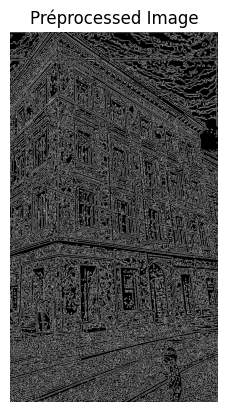

In [162]:
img = cv2.imread("./dataset/images_inter/04501.png", cv2.IMREAD_GRAYSCALE)
action = agent.choose_action()
imgo = agent.apply_actions(img, action)
# now lets see the image after the action
plt.imshow(imgo, cmap="gray")  # Assurez-vous que l'image est en niveaux de gris
plt.title("Préprocessed Image")
plt.axis("off")
plt.show()

In [163]:
reward = agent.calculate_reward(imgo, img)

In [166]:
agent.Q_table

{(('filter', 'mean', frozenset({('kernel_size', 5)})),
  ('contrast', 'equalization', frozenset()),
  ('threshold', 'local', frozenset({('C', 0), ('block_size', 7)})),
  ('segmentation',
   'canny',
   frozenset({('aperture_size', 3),
              ('threshold1', 100),
              ('threshold2', 200)}))): 0.0023408025234763433}

In [165]:
agent.update_Q(action, reward)

## Train the agent

In [174]:
image = cv2.imread("./dataset/images_inter/04501.png", cv2.IMREAD_GRAYSCALE)
image_gt = cv2.imread("./dataset/gt_edge_inter/04501.png", cv2.IMREAD_GRAYSCALE)
agent.train(image, image_gt, episodes=100)

Episode 10/100: Reward = 0.5056, Epsilon = 0.1000
Episode 20/100: Reward = 0.0001, Epsilon = 0.1000
Episode 30/100: Reward = 0.5056, Epsilon = 0.1000
Episode 40/100: Reward = 0.5056, Epsilon = 0.1000
Episode 50/100: Reward = 0.5056, Epsilon = 0.1000
Episode 60/100: Reward = 0.5056, Epsilon = 0.1000
Episode 70/100: Reward = 0.5056, Epsilon = 0.1000
Episode 80/100: Reward = 0.5056, Epsilon = 0.1000
Episode 90/100: Reward = 0.5027, Epsilon = 0.1000
Episode 100/100: Reward = 0.5056, Epsilon = 0.1000


In [176]:
#  now we will train the agent on the whole data set
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_dataset(image_dir, gt_dir):
    dataset = []
    for file_name in os.listdir(image_dir):
        image_path = os.path.join(image_dir, file_name)
        gt_path = os.path.join(gt_dir, file_name)
        if os.path.exists(image_path) and os.path.exists(gt_path):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
            dataset.append((image, gt))
    return dataset


In [179]:
# Load the dataset
dataset = load_dataset("./dataset/images_inter", "./dataset/gt_edge_inter")

# Split into training and testing sets
train_set, test_set = train_test_split(dataset, test_size=0.5, random_state=42)


In [180]:
for idx, (image, gt) in enumerate(train_set):
    print(f"Training on image {idx + 1}/{len(train_set)}")
    agent.train(image, gt, episodes=100)

Training on image 1/80
Episode 10/100: Reward = 0.5051, Epsilon = 0.1000
Episode 20/100: Reward = 0.5051, Epsilon = 0.1000
Episode 30/100: Reward = 0.5051, Epsilon = 0.1000
Episode 40/100: Reward = 0.5051, Epsilon = 0.1000
Episode 50/100: Reward = 0.5051, Epsilon = 0.1000
Episode 60/100: Reward = 0.5051, Epsilon = 0.1000
Episode 70/100: Reward = 0.5051, Epsilon = 0.1000
Episode 80/100: Reward = 0.5051, Epsilon = 0.1000
Episode 90/100: Reward = 0.5051, Epsilon = 0.1000
Episode 100/100: Reward = 0.5051, Epsilon = 0.1000
Training on image 2/80
Episode 10/100: Reward = 0.7500, Epsilon = 0.1000
Episode 20/100: Reward = 0.7500, Epsilon = 0.1000
Episode 30/100: Reward = 0.0000, Epsilon = 0.1000
Episode 40/100: Reward = 0.7500, Epsilon = 0.1000
Episode 50/100: Reward = 0.7500, Epsilon = 0.1000
Episode 60/100: Reward = 0.7500, Epsilon = 0.1000
Episode 70/100: Reward = 0.7500, Epsilon = 0.1000
Episode 80/100: Reward = 0.7500, Epsilon = 0.1000
Episode 90/100: Reward = 0.7500, Epsilon = 0.1000
Epi

In [181]:
# now that the agent is tarined we can get the best rewards for each combinations
agent.Q_table

{(('filter', 'median', frozenset({('kernel_size', 3)})),
  ('contrast', 'equalization', frozenset()),
  ('threshold', 'global', frozenset({('threshold', 100)})),
  ('segmentation',
   'sobel',
   frozenset({('delta', 0),
              ('ksize', 3),
              ('scale', 2.0)}))): 0.622024688530775,
 (('filter', 'gaussian', frozenset({('kernel_size', 7), ('sigmaX', 1.0)})),
  ('contrast',
   'clahe',
   frozenset({('clip_limit', 3.0), ('tile_grid_size', 16)})),
  ('threshold', 'local', frozenset({('C', 0), ('block_size', 3)})),
  ('segmentation',
   'canny',
   frozenset({('aperture_size', 5),
              ('threshold1', 50),
              ('threshold2', 200)}))): 0.0021687644136553193,
 (('filter', 'median', frozenset({('kernel_size', 5)})),
  ('contrast',
   'clahe',
   frozenset({('clip_limit', 1.0), ('tile_grid_size', 16)})),
  ('threshold', 'global', frozenset({('threshold', 150)})),
  ('segmentation',
   'canny',
   frozenset({('aperture_size', 5),
              ('threshold1', 

In [188]:
def display_best_parameters(Q_table):
    # Dictionary to store the best parameters for each combination
    best_params = {}

    for state_action, q_value in Q_table.items():
        # Extract the combination of operations and parameters (state)
        state = state_action[0]  # The combination of operations and parameters

        # Check if the state is already in best_params
        if state not in best_params:
            best_params[state] = (state_action, q_value)
        else:
            # Compare the current Q-value with the stored one and update if better
            _, best_q_value = best_params[state]
            if q_value > best_q_value:
                best_params[state] = (state_action, q_value)

    # Display the best parameters for each combination
    for state, (best_state_action, best_q_value) in best_params.items():
        print(f"Combination: {best_state_action}")
        print(f"Best Parameters: {best_state_action[1]}")  # The parameters of the operation
        print(f"Q-value: {best_q_value}")
        print("-" * 40)


In [189]:
display_best_parameters(agent.Q_table)

Combination: (('filter', 'median', frozenset({('kernel_size', 3)})), ('contrast', 'equalization', frozenset()), ('threshold', 'global', frozenset({('threshold', 100)})), ('segmentation', 'sobel', frozenset({('ksize', 3), ('scale', 2.0), ('delta', 0)})))
Best Parameters: ('contrast', 'equalization', frozenset())
Q-value: 0.622024688530775
----------------------------------------
Combination: (('filter', 'gaussian', frozenset({('kernel_size', 7), ('sigmaX', 1.0)})), ('contrast', 'equalization', frozenset()), ('threshold', 'global', frozenset({('threshold', 100)})), ('segmentation', 'sobel', frozenset({('scale', 1.0), ('delta', 0), ('ksize', 5)})))
Best Parameters: ('contrast', 'equalization', frozenset())
Q-value: 0.07971357270097569
----------------------------------------
Combination: (('filter', 'median', frozenset({('kernel_size', 5)})), ('contrast', 'equalization', frozenset()), ('threshold', 'global', frozenset({('threshold', 150)})), ('segmentation', 'canny', frozenset({('threshol

In [190]:
def display_best_action(Q_table):
    # Find the action with the highest Q-value
    best_action = max(Q_table, key=Q_table.get)
    best_q_value = Q_table[best_action]

    # Display the best action and its Q-value
    print(f"Best Action: {best_action}")
    print(f"Q-value: {best_q_value}")
    print("-" * 40)

In [191]:
display_best_action(agent.Q_table)

Best Action: (('filter', 'median', frozenset({('kernel_size', 3)})), ('contrast', 'equalization', frozenset()), ('threshold', 'global', frozenset({('threshold', 100)})), ('segmentation', 'sobel', frozenset({('ksize', 3), ('scale', 2.0), ('delta', 0)})))
Q-value: 0.622024688530775
----------------------------------------


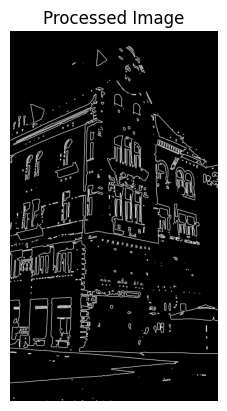

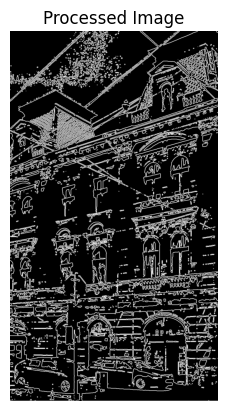

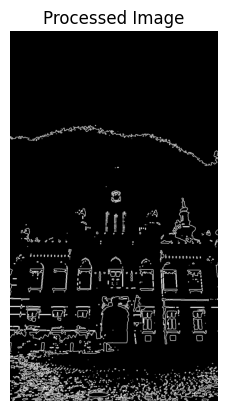

In [195]:
# apply the action with the best q value (the best combination)
import random
import cv2

# Choose a few random images from the test set
test_images = random.sample(test_set, 3)  # Assuming self.testdata contains the test images

# Get the best action from the Q-table
best_action_key = max(agent.Q_table, key=agent.Q_table.get)

best_action = [
    (step_type, method, dict(params)) for step_type, method, params in
    [(step[0], step[1], dict(step[2])) for step in best_action_key]
]

for idx, (image, gt) in enumerate(test_images):
    processed_img = agent.apply_actions(image, best_action)
    plt.imshow(processed_img, cmap="gray")
    plt.title("Processed Image")
    plt.axis("off")
    plt.show()
